In [1]:
# Synthetic People Analytics dataset for Promotion Prediction
# Author: You
# Goal: Create a realistic tabular dataset for modeling "promoted_within_12m"

import numpy as np
import pandas as pd

def generate_people_analytics_data(n=5000, seed=42):
    rng = np.random.default_rng(seed)

    # ---- Categorical spaces (PwC-flavored) ----
    departments = ["Assurance", "Tax", "Advisory", "Deals", "Risk", "Tech_AI", "HR"]
    role_levels = ["Associate", "Senior_Associate", "Manager"]  # predict next-step promotion
    educ_levels = ["Bachelor", "Master", "PhD"]
    locations = ["Amsterdam", "Rotterdam", "Utrecht", "Eindhoven", "The_Hague", "Groningen"]
    hire_sources = ["Referral", "Campus", "Agency", "Direct"]
    genders = ["Male", "Female", "Other/NA"]

    # ---- Base distributions ----
    dept = rng.choice(departments, size=n, p=[0.30, 0.18, 0.22, 0.08, 0.08, 0.10, 0.04])
    role = rng.choice(role_levels, size=n, p=[0.55, 0.35, 0.10])
    gender = rng.choice(genders, size=n, p=[0.49, 0.49, 0.02])
    edu = rng.choice(educ_levels, size=n, p=[0.45, 0.48, 0.07])
    loc = rng.choice(locations, size=n)
    hire_src = rng.choice(hire_sources, size=n, p=[0.28, 0.30, 0.20, 0.22])

    # ---- Tenure & age correlated with role & education ----
    # Tenure in months: Associates newer; Managers longer
    tenure_mu = np.select(
        [role=="Associate", role=="Senior_Associate", role=="Manager"],
        [18, 42, 84], default=36
    )
    tenure = np.clip(rng.normal(tenure_mu, 10), 3, 180).round()

    # Age: somewhat tied to education & role
    base_age = rng.normal(30, 4, size=n)
    base_age += np.where(edu=="Master", 1.5, 0)
    base_age += np.where(edu=="PhD", 3.5, 0)
    base_age += np.select(
        [role=="Associate", role=="Senior_Associate", role=="Manager"],
        [0, 3, 7], default=0
    )
    age = np.clip(base_age, 21, 65).round()

    # ---- Performance & manager rating (correlated) ----
    performance = np.clip(rng.normal(3.4, 0.6, size=n), 1.0, 5.0)
    manager_rating = np.clip(performance + rng.normal(0, 0.4, size=n), 1.0, 5.0)

    # ---- Utilization (billable ratio), projects, client satisfaction ----
    # Dept patterns: Assurance/Tax/Advisory higher utilization; Tech_AI varies
    dept_util_shift = np.select(
        [
            dept=="Assurance", dept=="Tax", dept=="Advisory",
            dept=="Deals", dept=="Risk", dept=="Tech_AI", dept=="HR"
        ],
        [0.12, 0.10, 0.10, 0.05, 0.00, -0.02, -0.08],
        default=0.0
    )
    utilization = np.clip(rng.normal(0.70 + dept_util_shift, 0.10), 0.20, 1.0)

    # Projects/year by dept
    base_lambda = np.select(
        [
            dept=="Assurance", dept=="Tax", dept=="Advisory",
            dept=="Deals", dept=="Risk", dept=="Tech_AI", dept=="HR"
        ],
        [8, 7, 6, 4, 5, 6, 3],
        default=5
    )
    projects_year = rng.poisson(lam=np.maximum(1, base_lambda))

    # Client satisfaction more relevant for client-facing depts
    client_sat = np.clip(
        rng.normal(3.6, 0.5, size=n)
        + np.where(np.isin(dept, ["Assurance","Advisory","Deals","Tax"]), 0.2, -0.1),
        1.0, 5.0
    )

    # ---- Learning & credentials ----
    trainings_completed = rng.poisson(lam=np.maximum(0.5, 2 + (performance-3.5)))
    certifications = rng.poisson(lam=np.maximum(0.3, 0.6 + (role!="Associate")*0.4 + (dept=="Tech_AI")*0.5))

    # ---- Work patterns ----
    remote_ratio = np.clip(rng.normal(0.4, 0.25, size=n) + (dept=="Tech_AI")*0.15, 0, 1)
    overtime_hours_m = np.clip(
        rng.normal(12, 6, size=n)
        + (dept=="Assurance")*4 + (dept=="Deals")*5 + (dept=="Tax")*3,
        0, 80
    )
    travel_days_m = np.clip(
        rng.normal(2.5, 2.0, size=n)
        + (dept=="Deals")*1.5 + (dept=="Assurance")*1.0,
        0, 15
    )

    # ---- Engagement, mentoring, moves, warnings ----
    engagement = np.clip(
        rng.normal(72, 12, size=n)
        + (manager_rating-3.5)*4
        - (overtime_hours_m-10)*0.6,
        0, 100
    )
    has_mentor = rng.choice([0,1], size=n, p=[0.55, 0.45])
    prior_internal_moves = rng.poisson(lam=np.maximum(0.2, tenure/36.0))  # more tenure -> more moves
    warnings = rng.choice([0,1], size=n, p=[0.96, 0.04])

    # ---- Compensation (banded), pay raise, bonus ----
    # Rough salary bands by role; market percentile ~ N(50,15)
    band_base = np.select([role=="Associate", role=="Senior_Associate", role=="Manager"], [1, 2, 3], default=2)
    salary_band = band_base + (dept=="Tech_AI")*1  # Tech/AI tends to higher band at same level
    market_salary_pctile = np.clip(rng.normal(55, 15, size=n), 5, 99)

    pay_raise_pct = np.clip(
        rng.normal(4.0, 1.8, size=n)
        + (performance-3.5)*0.9
        + (salary_band-2)*0.5,
        0, 12
    )
    bonus_received = rng.choice([0,1], size=n, p=[0.35, 0.65])  # many consulting roles have bonuses

    # ---- Team & manager context ----
    team_size = np.clip(
        rng.normal(7, 3, size=n)
        + (role=="Manager")*4
        + (dept=="Assurance")*2,
        2, 40
    ).round()
    manager_tenure_yr = np.clip(rng.normal(5, 2.5, size=n) + (dept=="Assurance")*1.0, 0.5, 20)

    # ---- Eligibility & time since last promotion ----
    months_since_last_promo = np.clip(
        rng.normal(18, 8, size=n) + (role=="Senior_Associate")*10 + (role=="Manager")*16,
        0, 120
    ).round()
    eligible_flag = (months_since_last_promo >= 12).astype(int)

    # ---- Latent "propensity for promotion" logit ----
    # Start with a baseline per role (Associates get promoted more frequently to Senior_Associate)
    base_logit = np.select(
        [role=="Associate", role=="Senior_Associate", role=="Manager"],
        [ -0.2, -0.6, -1.0 ],  # becoming Sr_Assoc is easier than Sr_Assoc->Manager, etc.
        default=-0.5
    )

    # Department effects on promotion velocity (stylized)
    dept_logit = np.select(
        [
            dept=="Assurance", dept=="Tax", dept=="Advisory",
            dept=="Deals", dept=="Risk", dept=="Tech_AI", dept=="HR"
        ],
        [0.10, -0.05, 0.15, 0.05, 0.00, 0.12, -0.10],
        default=0.0
    )

    # Manager strictness as a random effect
    manager_strictness = rng.normal(0.0, 0.45, size=n)

    # Key drivers (scaled heuristically)
    logit = (
        base_logit
        + dept_logit
        + 0.55*(performance-3.5)
        + 0.35*(manager_rating-3.5)
        + 0.25*(utilization-0.7)/0.1       # utilization near 0.7 is good
        - 0.12*np.maximum(0, utilization-0.9)/0.05  # overutilization hurts (burnout signal)
        + 0.18*(client_sat-3.5)
        + 0.02*(trainings_completed)
        + 0.10*(certifications>=1)
        + 0.20*(has_mentor==1)
        + 0.02*np.clip((engagement-70), -40, 40)
        - 0.015*(overtime_hours_m-10)
        - 0.06*warnings
        + 0.02*np.clip((pay_raise_pct-4), -4, 8)
        + 0.03*np.clip((market_salary_pctile-55), -30, 40)
        + 0.03*np.clip((prior_internal_moves), 0, 5)
        + 0.20*(eligible_flag==1)
        + manager_strictness
    )

    # Interaction: tenure sweet spot (too low or too high reduces momentum)
    tenure_years = tenure/12.0
    logit += -0.10*np.abs(tenure_years - 3.0)  # best around ~3 years in level/company

    # Mild fairness/bias signal to study mitigation later (and show ethics awareness)
    # Note: negative coefficient for female unless mentor present (mitigation effect)
    gender_bias = np.where(gender=="Female", -0.12, 0.0) + np.where((gender=="Female") & (has_mentor==1), 0.10, 0.0)
    logit += gender_bias

    # Convert to probability via sigmoid
    prob = 1/(1 + np.exp(-logit))

    # Bernoulli draw for target; ensure non-eligible folks rarely get promoted
    prob_adj = np.where(eligible_flag==1, prob, prob*0.15)
    promoted = rng.binomial(1, np.clip(prob_adj, 0.01, 0.99))

    # Optional: synthetic "time_to_promotion_months" for those promoted (right-censored for others)
    time_to_promo = np.where(
        promoted==1,
        np.clip(rng.normal(6, 2.5, size=n), 1, 12).round(),
        np.nan
    )

    # ---- Assemble DataFrame ----
    df = pd.DataFrame({
        "employee_id": np.arange(1, n+1),
        "department": dept,
        "role_level": role,
        "gender": gender,
        "education": edu,
        "location": loc,
        "hire_source": hire_src,
        "age": age.astype(int),
        "tenure_months": tenure.astype(int),
        "months_since_last_promo": months_since_last_promo.astype(int),
        "eligible_for_promo": eligible_flag.astype(int),
        "performance_rating": np.round(performance, 2),
        "manager_rating": np.round(manager_rating, 2),
        "billable_utilization": np.round(utilization, 3),
        "projects_per_year": projects_year.astype(int),
        "client_satisfaction": np.round(client_sat, 2),
        "trainings_completed": trainings_completed.astype(int),
        "certifications_count": certifications.astype(int),
        "remote_ratio": np.round(remote_ratio, 3),
        "overtime_hours_month": np.round(overtime_hours_m, 1),
        "travel_days_month": np.round(travel_days_m, 1),
        "engagement_score": np.round(engagement, 1),
        "has_mentor": has_mentor.astype(int),
        "prior_internal_moves": prior_internal_moves.astype(int),
        "warnings_flag": warnings.astype(int),
        "salary_band": salary_band.astype(int),
        "market_salary_pctile": np.round(market_salary_pctile, 1),
        "pay_raise_pct": np.round(pay_raise_pct, 2),
        "bonus_received": bonus_received.astype(int),
        "team_size": team_size.astype(int),
        "manager_tenure_years": np.round(manager_tenure_yr, 1),
        "promotion_probability": np.round(prob_adj, 4),
        "promoted_within_12m": promoted.astype(int),
        "time_to_promotion_months": time_to_promo
    })

    # Helpful splits for modeling later
    # (keep protected attributes for fairness analysis; you can drop them for baseline model)
    return df

# Generate and save dataset
df = generate_people_analytics_data(n=6000, seed=7)
df.to_csv("people_analytics_promotion.csv", index=False)


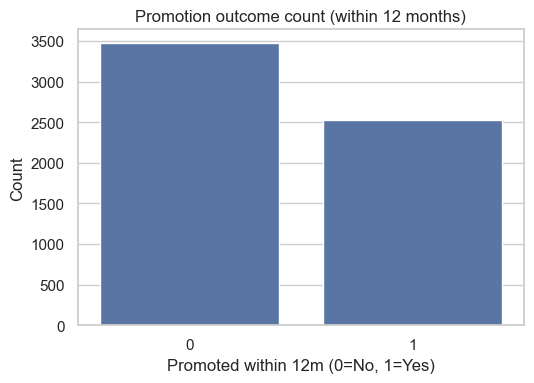

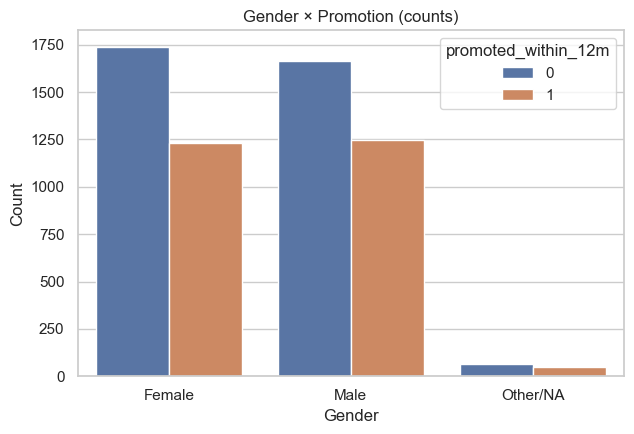

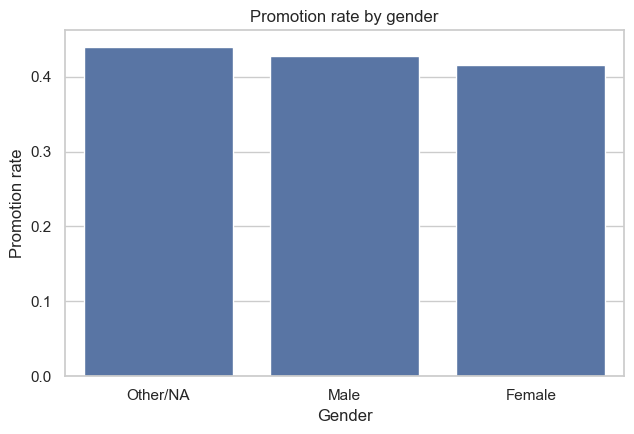

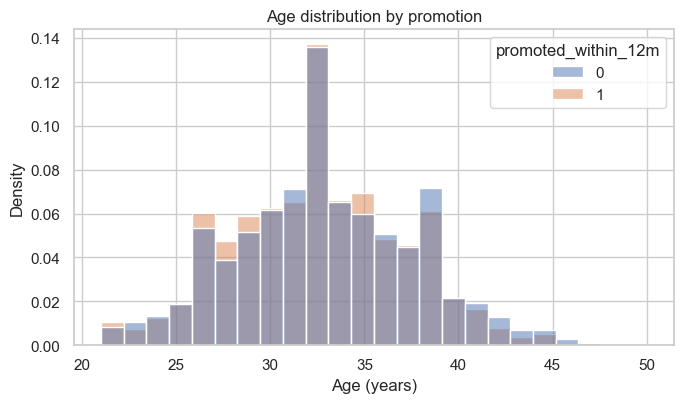

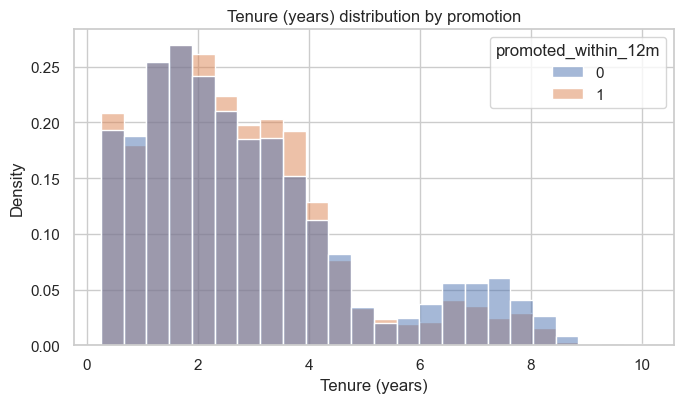

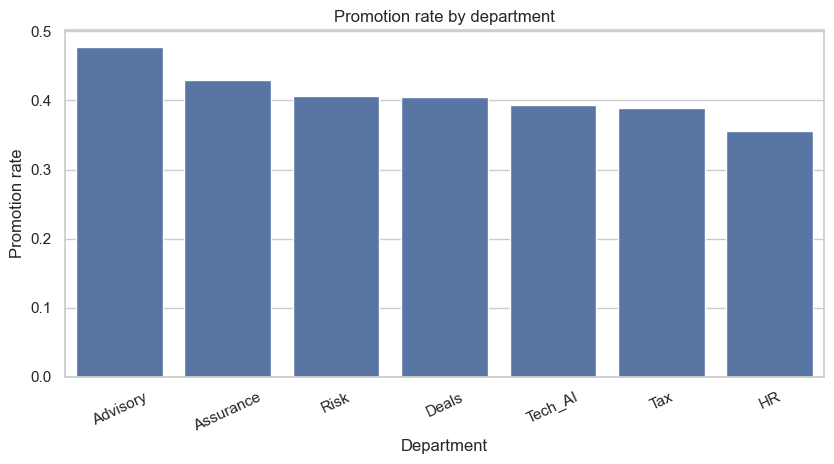

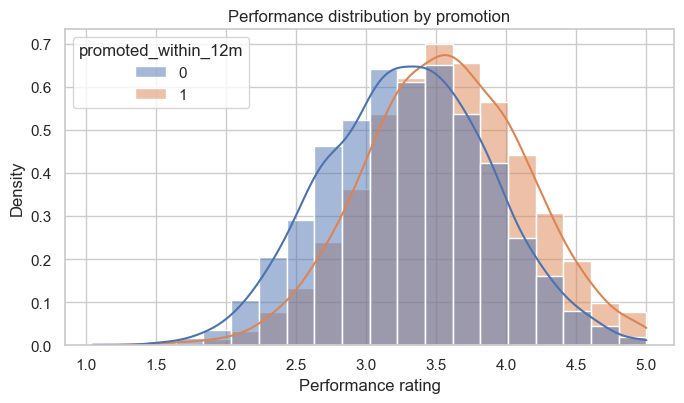

C:\Users\cstam\AppData\Local\Temp\ipykernel_24748\2388118965.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  perf_rate_tab = df.groupby(perf_bins)["promoted_within_12m"].mean().reset_index()


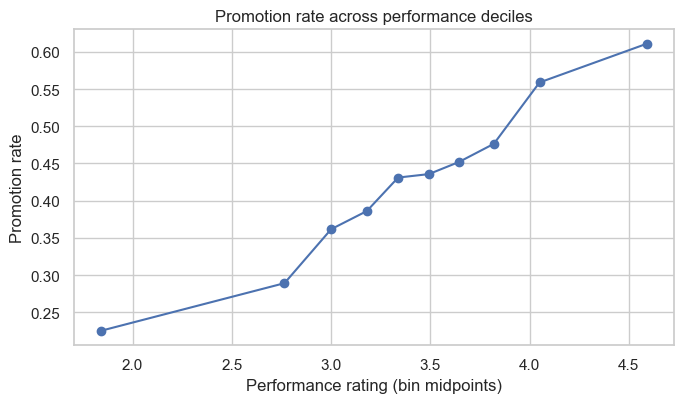

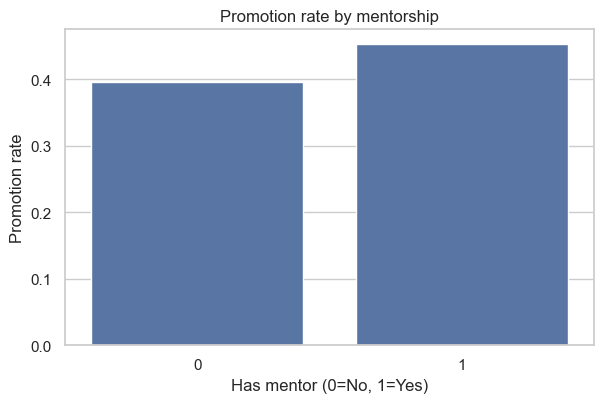

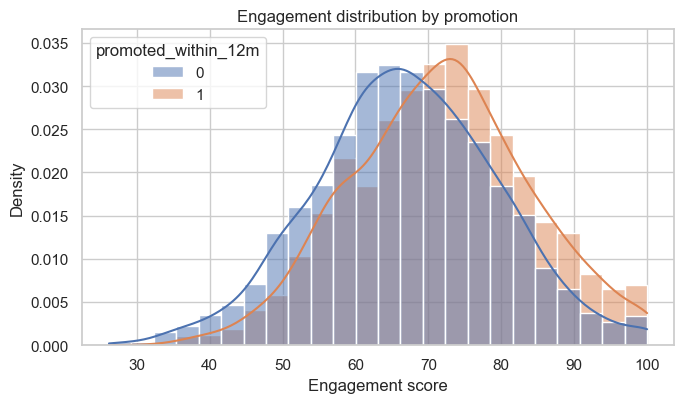

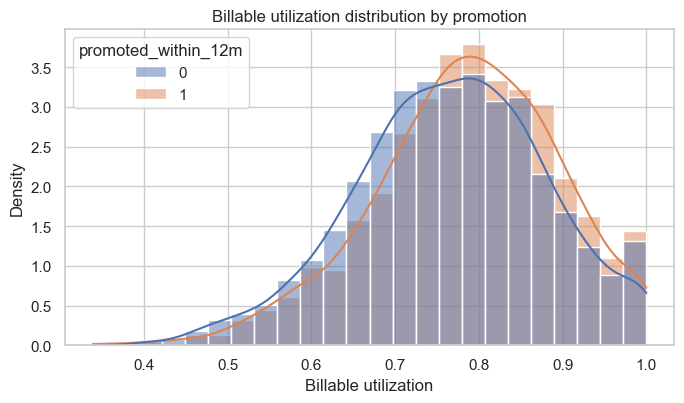

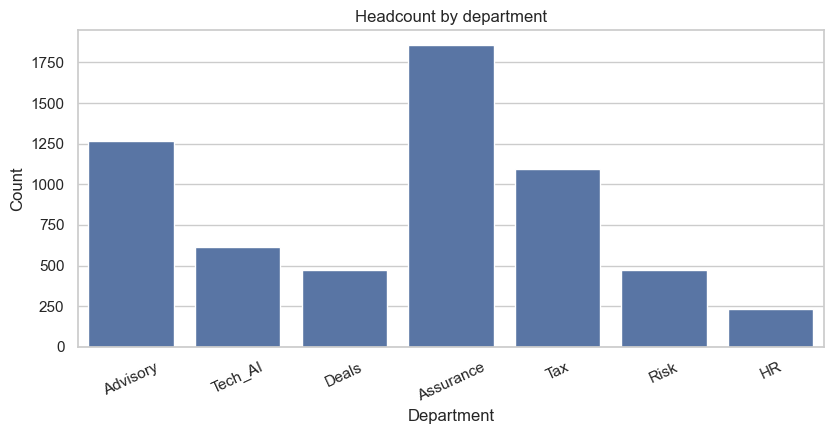

Saved plots and tables to: C:\Users\cstam\plots_promotion_eda


In [6]:
# ============================================
# EDA plots for Promotion Case — reliable save & show
# ============================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# If needed:
# df = pd.read_csv("people_analytics_promotion.csv")

# ---------- Setup ----------
plt.close('all')
sns.set(style="whitegrid")
pd.set_option("display.max_columns", 100)

IMG_DIR = "plots_promotion_eda"
os.makedirs(IMG_DIR, exist_ok=True)

assert "promoted_within_12m" in df.columns, "Expected column 'promoted_within_12m' missing."

def finalize(fig, filename):
    """Save first (to avoid blank files), then show, then close."""
    fig.tight_layout()
    fig.savefig(os.path.join(IMG_DIR, filename), dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

def rate_table(cat_col, target_col="promoted_within_12m", sort=True):
    tab = (
        df.groupby(cat_col)[target_col]
        .agg(['count', 'mean'])
        .rename(columns={'count':'n', 'mean':'promotion_rate'})
        .reset_index()
    )
    if sort:
        tab = tab.sort_values('promotion_rate', ascending=False)
    return tab

def hist_by_class(feature, target='promoted_within_12m', bins=30, kde=False, filename=None, xlabel=None, title=None):
    fig, ax = plt.subplots(figsize=(7,4.2))
    sns.histplot(data=df, x=feature, hue=target, bins=bins, kde=kde,
                 stat="density", common_norm=False, ax=ax)
    ax.set_title(title or f"{feature} distribution by promotion")
    if xlabel:
        ax.set_xlabel(xlabel)
    if filename:
        finalize(fig, filename)
    else:
        plt.show()
        plt.close(fig)

# 1) Promotion outcome balance (class balance)
fig, ax = plt.subplots(figsize=(5.5,4))
sns.countplot(data=df, x="promoted_within_12m", ax=ax)
ax.set_title("Promotion outcome count (within 12 months)")
ax.set_xlabel("Promoted within 12m (0=No, 1=Yes)")
ax.set_ylabel("Count")
finalize(fig, "01_outcome_balance.png")

# 2) Gender × Promotion (counts)
fig, ax = plt.subplots(figsize=(6.5,4.5))
sns.countplot(data=df, x="gender", hue="promoted_within_12m", ax=ax)
ax.set_title("Gender × Promotion (counts)")
ax.set_xlabel("Gender")
ax.set_ylabel("Count")
finalize(fig, "02_gender_promotion_counts.png")

# 2b) Gender × Promotion (rates %)
gender_rates = rate_table("gender")
fig, ax = plt.subplots(figsize=(6.5,4.5))
sns.barplot(data=gender_rates, x="gender", y="promotion_rate", ax=ax)
ax.set_title("Promotion rate by gender")
ax.set_ylabel("Promotion rate")
ax.set_xlabel("Gender")
finalize(fig, "02b_gender_promotion_rates.png")

# 3) Age distribution by Promotion
hist_by_class("age", bins=24, kde=False,
              filename="03_age_distribution_by_promotion.png",
              xlabel="Age (years)",
              title="Age distribution by promotion")

# 4) Tenure distribution by Promotion (in years)
if "tenure_months" in df.columns:
    if "_tenure_years_" not in df.columns:
        df["_tenure_years_"] = df["tenure_months"] / 12.0
    hist_by_class("_tenure_years_", bins=24, kde=False,
                  filename="04_tenure_years_distribution_by_promotion.png",
                  xlabel="Tenure (years)",
                  title="Tenure (years) distribution by promotion")

# 5) Department × Promotion rate
dept_rates = rate_table("department")
fig, ax = plt.subplots(figsize=(8.5,4.8))
sns.barplot(data=dept_rates, x="department", y="promotion_rate", ax=ax)
ax.set_title("Promotion rate by department")
ax.set_ylabel("Promotion rate")
ax.set_xlabel("Department")
ax.tick_params(axis='x', rotation=25)
finalize(fig, "05_department_promotion_rates.png")

# 6a) Performance rating × Promotion — distribution
if "performance_rating" in df.columns:
    hist_by_class("performance_rating", bins=20, kde=True,
                  filename="06a_performance_distribution_by_promotion.png",
                  xlabel="Performance rating",
                  title="Performance distribution by promotion")

    # 6b) Binned promotion rate by performance deciles
    perf_bins = pd.qcut(df["performance_rating"], q=10, duplicates='drop')
    perf_rate_tab = df.groupby(perf_bins)["promoted_within_12m"].mean().reset_index()
    perf_rate_tab["bin_mid"] = perf_rate_tab["performance_rating"].apply(lambda x: x.mid)

    fig, ax = plt.subplots(figsize=(7,4.2))
    ax.plot(perf_rate_tab["bin_mid"], perf_rate_tab["promoted_within_12m"], marker='o')
    ax.set_title("Promotion rate across performance deciles")
    ax.set_xlabel("Performance rating (bin midpoints)")
    ax.set_ylabel("Promotion rate")
    finalize(fig, "06b_performance_deciles_promotion_rate.png")

# 7) Mentorship effect
if "has_mentor" in df.columns:
    mentor_rates = rate_table("has_mentor")
    fig, ax = plt.subplots(figsize=(6.2,4.2))
    sns.barplot(data=mentor_rates, x="has_mentor", y="promotion_rate", ax=ax)
    ax.set_title("Promotion rate by mentorship")
    ax.set_xlabel("Has mentor (0=No, 1=Yes)")
    ax.set_ylabel("Promotion rate")
    finalize(fig, "07_mentorship_promotion_rates.png")

# 8) Engagement score × Promotion
if "engagement_score" in df.columns:
    hist_by_class("engagement_score", bins=24, kde=True,
                  filename="08_engagement_distribution_by_promotion.png",
                  xlabel="Engagement score",
                  title="Engagement distribution by promotion")

# 9) Utilization × Promotion (distribution) — optional
if "billable_utilization" in df.columns:
    hist_by_class("billable_utilization", bins=24, kde=True,
                  filename="09_utilization_distribution_by_promotion.png",
                  xlabel="Billable utilization",
                  title="Billable utilization distribution by promotion")

# 10) Department × Headcount
fig, ax = plt.subplots(figsize=(8.5,4.5))
sns.countplot(data=df, x="department", ax=ax)
ax.set_title("Headcount by department")
ax.set_xlabel("Department")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=25)
finalize(fig, "10_department_headcount.png")

# ----- Save summary tables as CSV for quick reference -----
gender_rates.to_csv(os.path.join(IMG_DIR, "table_gender_promotion_rates.csv"), index=False)
dept_rates.to_csv(os.path.join(IMG_DIR, "table_department_promotion_rates.csv"), index=False)

if "role_level" in df.columns:
    role_rates = rate_table("role_level")
    role_rates.to_csv(os.path.join(IMG_DIR, "table_role_level_promotion_rates.csv"), index=False)

if "has_mentor" in df.columns:
    mentor_rates.to_csv(os.path.join(IMG_DIR, "table_mentorship_promotion_rates.csv"), index=False)

if "performance_rating" in df.columns:
    perf_rate_tab.to_csv(os.path.join(IMG_DIR, "table_performance_deciles_promotion_rate.csv"), index=False)

print(f"Saved plots and tables to: {os.path.abspath(IMG_DIR)}")


In [8]:
# ============================================
# Numeric summary tables to "explain the plots"
# ============================================
import os
import pandas as pd
import numpy as np

# If needed:
# df = pd.read_csv("people_analytics_promotion.csv")

TABLES_DIR = "tables_promotion_summary"
os.makedirs(TABLES_DIR, exist_ok=True)

TARGET = "promoted_within_12m"

def counts_and_rate(series):
    """Return count_0, count_1, total, and rate_1 (mean) for a binary series."""
    s = series.astype(int)
    count_1 = int(s.sum())
    total = int(s.shape[0])
    count_0 = total - count_1
    rate_1 = float(s.mean())
    return pd.DataFrame(
        {
            "not_promoted": [count_0],
            "promoted": [count_1],
            "total": [total],
            "promotion_rate": [rate_1],
        }
    )

def categorical_summary(df, cat_col, target=TARGET, sort_by="promotion_rate", ascending=False):
    """Counts and promotion rate per category."""
    tab = (
        df.groupby(cat_col)[target]
        .agg(n="count", promoted="sum", promotion_rate="mean")
        .reset_index()
        .sort_values(sort_by, ascending=ascending)
    )
    tab["not_promoted"] = tab["n"] - tab["promoted"]
    # Reorder columns
    tab = tab[[cat_col, "n", "promoted", "not_promoted", "promotion_rate"]]
    return tab

def numeric_by_outcome(df, num_col, target=TARGET, quantiles=(0.1, 0.25, 0.5, 0.75, 0.9)):
    """Descriptive stats of a numeric feature split by outcome."""
    def _q(x):
        return x.quantile(quantiles).rename(index=lambda q: f"q{int(q*100)}")
    g = df.groupby(target)[num_col]
    out = g.agg(["count", "mean", "std", "min", "median", "max"])
    qs = g.apply(_q).unstack(level=0)
    # Merge stats and quantiles
    res = out.join(qs, how="left")
    # Column names: 0/1 -> No/Yes for readability
    res.columns = [
        (f"{num_col}|{c}" if isinstance(c, str) else f"{num_col}|q{int(c*100)}")
        for c in res.columns
    ]
    # Add a flat index with suffix per outcome for clarity
    res = res.T.reset_index()
    return res

def performance_deciles_rate(df, perf_col="performance_rating", target=TARGET):
    if perf_col not in df.columns:
        return None
    bins = pd.qcut(df[perf_col], q=10, duplicates="drop")
    tab = (
        df.groupby(bins)[target]
        .agg(n="count", promotion_rate="mean")
        .reset_index()
        .rename(columns={perf_col: "perf_bin"})
    )
    tab["bin_low"] = tab["perf_bin"].apply(lambda x: round(float(x.left), 2))
    tab["bin_high"] = tab["perf_bin"].apply(lambda x: round(float(x.right), 2))
    tab = tab[["bin_low", "bin_high", "n", "promotion_rate"]]
    return tab

def build_summary_tables(df):
    tables = {}

    # 0) Overall outcome counts and rate
    tables["overall"] = counts_and_rate(df[TARGET])

    # 1) Gender × promotion
    if "gender" in df.columns:
        tables["gender"] = categorical_summary(df, "gender")

    # 2) Department × promotion
    if "department" in df.columns:
        tables["department"] = categorical_summary(df, "department")

    # 3) Role level × promotion
    if "role_level" in df.columns:
        tables["role_level"] = categorical_summary(df, "role_level")

    # 4) Mentorship × promotion
    if "has_mentor" in df.columns:
        tables["mentorship"] = categorical_summary(df, "has_mentor")

    # 5) Performance deciles × promotion rate
    if "performance_rating" in df.columns:
        tables["performance_deciles"] = performance_deciles_rate(df)

    # 6) Numeric distributions by outcome (aligns with histogram plots)
    numeric_cols = [
        c for c in [
            "age",
            "tenure_months",
            "engagement_score",
            "billable_utilization",
            "performance_rating",
        ] if c in df.columns
    ]
    for col in numeric_cols:
        tables[f"numeric_{col}_by_outcome"] = numeric_by_outcome(df, col)

    # 7) Optional: Promotion rate by location / hire_source (useful for storylines)
    for extra in ["location", "hire_source"]:
        if extra in df.columns:
            tables[f"{extra}"] = categorical_summary(df, extra)

    return tables

def save_tables_as_csv(tables_dict, out_dir=TABLES_DIR):
    for name, tab in tables_dict.items():
        if tab is None:
            continue
        path = os.path.join(out_dir, f"{name}.csv")
        tab.to_csv(path, index=False)

# Build and save all summary tables
summary_tables = build_summary_tables(df)
save_tables_as_csv(summary_tables, out_dir=TABLES_DIR)

# Display the key ones in notebook
display(summary_tables["overall"])       # overall promoted vs not
display(summary_tables["gender"])        # promotion by gender
display(summary_tables["department"])    # promotion by department
display(summary_tables["role_level"])    # promotion by role level
display(summary_tables["mentorship"])    # promotion by mentorship


C:\Users\cstam\AppData\Local\Temp\ipykernel_24748\990776852.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(bins)[target]


,not_promoted,promoted,total,promotion_rate
0,3469,2531,6000,0.421833


,gender,n,promoted,not_promoted,promotion_rate
2,Other/NA,116,51,65,0.439655
1,Male,2911,1246,1665,0.428032
0,Female,2973,1234,1739,0.415069


,department,n,promoted,not_promoted,promotion_rate
0,Advisory,1265,604,661,0.477470
1,Assurance,1854,796,1058,0.429342
4,Risk,473,192,281,0.405920
2,Deals,470,190,280,0.404255
6,Tech_AI,612,241,371,0.393791
5,Tax,1093,425,668,0.388838
3,HR,233,83,150,0.356223


,role_level,n,promoted,not_promoted,promotion_rate
2,Senior_Associate,2133,949,1184,0.444913
0,Associate,3213,1377,1836,0.428571
1,Manager,654,205,449,0.313456


,has_mentor,n,promoted,not_promoted,promotion_rate
1,1,2709,1226,1483,0.452566
0,0,3291,1305,1986,0.396536


In [10]:
pip install xgboost

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ------- -------------------------------- 11.3/56.8 MB 68.3 MB/s eta 0:00:01
   ----------------- ---------------------- 24.6/56.8 MB 66.6 MB/s eta 0:00:01
   --------------------------------- ------ 47.4/56.8 MB 82.4 MB/s eta 0:00:01
   ---------------------------------------  56.6/56.8 MB 85.7 MB/s eta 0:00:01
   ---------------------------------------- 56.8/56.8 MB 69.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Fitting 5 folds for each of 7 candidates, totalling 35 fits

=== Logistic Regression (best) — Test Metrics ===
Accuracy:   0.699
Precision:  0.619
Recall:     0.747
F1-score:   0.677
ROC AUC:    0.782
PR AUC:     0.714

Confusion Matrix:
[[461 233]
 [128 378]]

Classification Report:
              precision    recall  f1-score   support

           0      0.783     0.664     0.719       694
           1      0.619     0.747     0.677       506

    accuracy                          0.699      1200
   macro avg      0.701     0.706     0.698      1200
weighted avg      0.714     0.699     0.701      1200



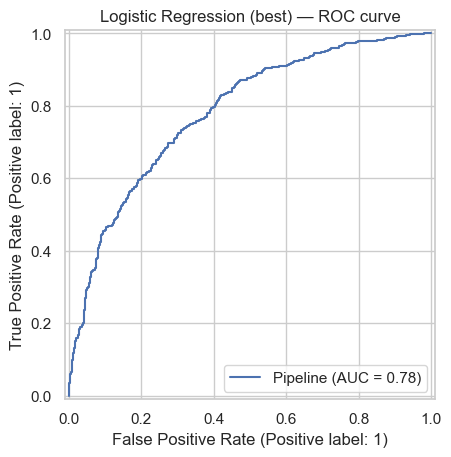

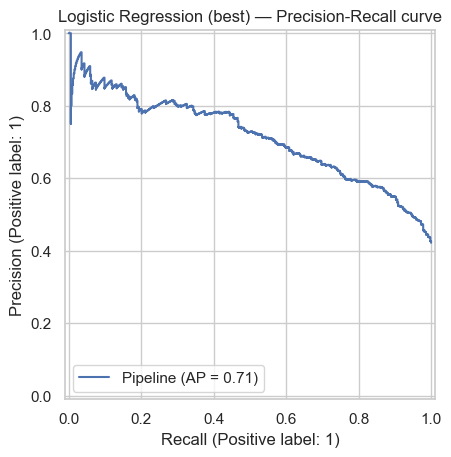

,feature,coef
3,eligible_for_promo,0.790973
19,market_salary_pctile,0.352757
14,engagement_score,0.260035
5,manager_rating,0.232477
4,performance_rating,0.223763
6,billable_utilization,0.175024
15,has_mentor,0.082397
8,client_satisfaction,0.073340
16,prior_internal_moves,0.073185
31,department_Tech_AI,0.071582


,feature,coef
13,travel_days_month,-0.003531
39,education_Master,-0.004066
41,location_Amsterdam,-0.011277
11,remote_ratio,-0.011726
21,bonus_received,-0.015905
22,team_size,-0.021825
50,hire_source_Referral,-0.025350
46,location_Utrecht,-0.031892
29,department_Risk,-0.034704
28,department_HR,-0.039253


Fitting 5 folds for each of 25 candidates, totalling 125 fits

=== Random Forest (best) — Test Metrics ===
Accuracy:   0.700
Precision:  0.629
Recall:     0.702
F1-score:   0.664
ROC AUC:    0.769
PR AUC:     0.702

Confusion Matrix:
[[485 209]
 [151 355]]

Classification Report:
              precision    recall  f1-score   support

           0      0.763     0.699     0.729       694
           1      0.629     0.702     0.664       506

    accuracy                          0.700      1200
   macro avg      0.696     0.700     0.696      1200
weighted avg      0.706     0.700     0.702      1200



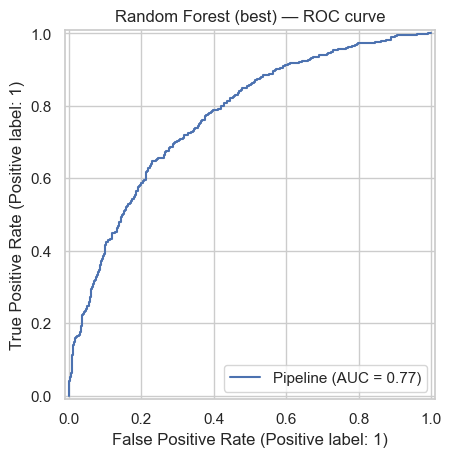

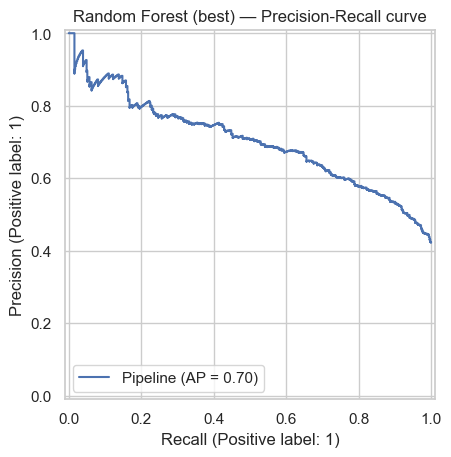

Could not compute permutation importances for RF: All arrays must be of the same length
Fitting 5 folds for each of 30 candidates, totalling 150 fits

=== XGBoost (best) — Test Metrics ===
Accuracy:   0.688
Precision:  0.611
Recall:     0.719
F1-score:   0.661
ROC AUC:    0.769
PR AUC:     0.709

Confusion Matrix:
[[462 232]
 [142 364]]

Classification Report:
              precision    recall  f1-score   support

           0      0.765     0.666     0.712       694
           1      0.611     0.719     0.661       506

    accuracy                          0.688      1200
   macro avg      0.688     0.693     0.686      1200
weighted avg      0.700     0.688     0.690      1200



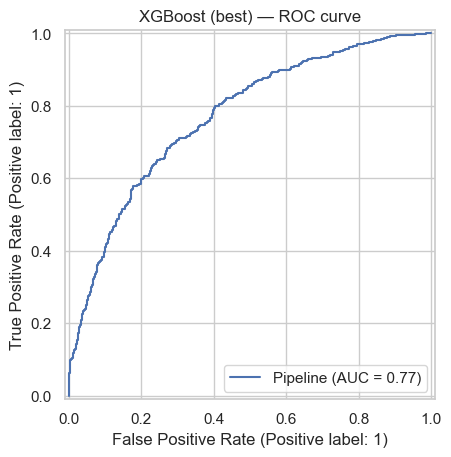

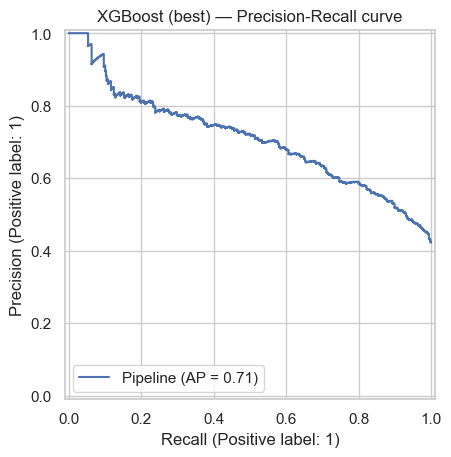

Could not compute permutation importances for XGB: All arrays must be of the same length


,model,accuracy,precision,recall,f1,roc_auc,pr_auc
0,Logistic Regression,0.699167,0.618658,0.747036,0.676813,0.781777,0.713664
2,XGBoost,0.688333,0.610738,0.719368,0.660617,0.769173,0.709457
1,Random Forest,0.700000,0.629433,0.701581,0.663551,0.768894,0.701689


In [11]:
# ============================================================
# ML Modeling: Promotion Prediction (LR, RF, XGBoost)
# Mirrors the structure of the insurance-fraud notebook,
# extended with XGBoost.
# ============================================================

# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# If xgboost is not available, install it in the notebook:
# !pip install xgboost
try:
    from xgboost import XGBClassifier
except ImportError as e:
    raise ImportError("xgboost is not installed. Run `pip install xgboost` in your notebook and re-run.") from e

# ============================================================
# 1) Prepare features & target
# ============================================================

TARGET = "promoted_within_12m"

# Columns to drop to avoid leakage or IDs
drop_cols = [
    "employee_id",                   # identifier
    "promotion_probability",         # synthetic ground-truth propensity (leakage)
    "time_to_promotion_months"       # post-outcome info for some individuals
]

# Keep only columns that exist in df
drop_cols = [c for c in drop_cols if c in df.columns]

# X, y
X = df.drop(columns=drop_cols + [TARGET])
y = df[TARGET].astype(int)

# Detect categorical vs numeric (object and category -> categorical)
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

# ============================================================
# 2) Train / Test split (stratified)
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Class balance for XGBoost's scale_pos_weight
pos = int(y_train.sum())
neg = int(y_train.shape[0] - pos)
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

# ============================================================
# 3) Preprocessing pipelines
#    - Numeric: impute median, scale
#    - Categorical: impute most-frequent, One-Hot
# ============================================================

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

# Utility: get feature names after preprocessing (for importances)
def get_feature_names(preprocessor, num_cols, cat_cols):
    num_features = num_cols
    ohe = preprocessor.named_transformers_["cat"].named_steps["ohe"]
    cat_features = ohe.get_feature_names_out(cat_cols).tolist()
    return num_features + cat_features

# ============================================================
# 4) Helper: evaluation & plots (ROC, PR, confusion matrix)
# ============================================================

def evaluate_model(clf, X_test, y_test, name="model"):
    """Print metrics, show ROC/PR curves, confusion matrix."""
    y_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    roc  = roc_auc_score(y_test, y_proba)
    pr   = average_precision_score(y_test, y_proba)

    print(f"\n=== {name} — Test Metrics ===")
    print(f"Accuracy:   {acc:0.3f}")
    print(f"Precision:  {prec:0.3f}")
    print(f"Recall:     {rec:0.3f}")
    print(f"F1-score:   {f1:0.3f}")
    print(f"ROC AUC:    {roc:0.3f}")
    print(f"PR AUC:     {pr:0.3f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    # ROC curve
    RocCurveDisplay.from_estimator(clf, X_test, y_test)
    plt.title(f"{name} — ROC curve")
    plt.show()

    # Precision-Recall curve
    PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)
    plt.title(f"{name} — Precision-Recall curve")
    plt.show()

# ============================================================
# 5) Logistic Regression (baseline, interpretable)
#    - Class-weight balanced due to potential skew
#    - Simple hyperparameter search on C
# ============================================================

logit_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        solver="lbfgs", max_iter=2000, class_weight="balanced", n_jobs=-1
    ))
])

logit_param_grid = {
    "model__C": np.logspace(-2, 2, 7)  # 0.01 ... 100
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logit_search = RandomizedSearchCV(
    estimator=logit_pipe,
    param_distributions=logit_param_grid,
    n_iter=7,
    scoring="roc_auc",
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42,
    refit=True
)

logit_search.fit(X_train, y_train)
evaluate_model(logit_search.best_estimator_, X_test, y_test, name="Logistic Regression (best)")

# Coefficients: map back to feature names
# NOTE: Only meaningful if preprocessor is fitted (it is, via best_estimator_)
try:
    fitted_pre = logit_search.best_estimator_.named_steps["preprocess"]
    feature_names = get_feature_names(fitted_pre, num_cols, cat_cols)
    coefs = logit_search.best_estimator_.named_steps["model"].coef_[0]
    logit_coeffs = pd.DataFrame({"feature": feature_names, "coef": coefs}).sort_values("coef", ascending=False)
    display(logit_coeffs.head(20))
    display(logit_coeffs.tail(20))
except Exception as e:
    print("Could not extract logistic coefficients:", e)

# ============================================================
# 6) Random Forest (nonlinear benchmark)
#    - RandomizedSearchCV over sensible ranges
# ============================================================

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=400, random_state=42, n_jobs=-1, class_weight="balanced"
    ))
])

rf_param_grid = {
    "model__max_depth": [None, 6, 10, 14, 18, 24],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 4, 8],
    "model__max_features": ["sqrt", "log2", 0.3, 0.5, None]
}

rf_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_grid,
    n_iter=25,                # reduce to 10 if time is tight
    scoring="roc_auc",
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42,
    refit=True
)

rf_search.fit(X_train, y_train)
evaluate_model(rf_search.best_estimator_, X_test, y_test, name="Random Forest (best)")

# Feature importances (Permutation importance for robustness)
try:
    rf_best = rf_search.best_estimator_
    result = permutation_importance(rf_best, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring="roc_auc")
    fitted_pre = rf_best.named_steps["preprocess"]
    feature_names = get_feature_names(fitted_pre, num_cols, cat_cols)
    perm_imp = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std
    }).sort_values("importance_mean", ascending=False)
    display(perm_imp.head(25))
except Exception as e:
    print("Could not compute permutation importances for RF:", e)

# ============================================================
# 7) XGBoost (gradient boosting, advanced model)
#    - Uses scale_pos_weight for imbalance
#    - RandomizedSearchCV on key parameters
# ============================================================

xgb_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_estimators=500,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=6,
        reg_lambda=1.0,
        reg_alpha=0.0,
        random_state=42,
        n_jobs=-1,
        tree_method="hist",
        scale_pos_weight=scale_pos_weight
    ))
])

xgb_param_grid = {
    "model__max_depth": [3, 4, 5, 6, 8],
    "model__min_child_weight": [1, 2, 5, 10],
    "model__subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "model__gamma": [0, 0.1, 0.2, 0.3],
    "model__reg_lambda": [0.5, 1.0, 2.0, 5.0],
    "model__reg_alpha": [0.0, 0.1, 0.5, 1.0],
    "model__learning_rate": [0.03, 0.05, 0.08, 0.1]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=xgb_param_grid,
    n_iter=30,               # reduce to 15 if time is tight
    scoring="roc_auc",
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42,
    refit=True
)

xgb_search.fit(X_train, y_train)
evaluate_model(xgb_search.best_estimator_, X_test, y_test, name="XGBoost (best)")

# Permutation importances for XGB (model-agnostic)
try:
    xgb_best = xgb_search.best_estimator__
except AttributeError:
    xgb_best = xgb_search.best_estimator_
try:
    result = permutation_importance(xgb_best, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring="roc_auc")
    fitted_pre = xgb_best.named_steps["preprocess"]
    feature_names = get_feature_names(fitted_pre, num_cols, cat_cols)
    xgb_perm_imp = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std
    }).sort_values("importance_mean", ascending=False)
    display(xgb_perm_imp.head(25))
except Exception as e:
    print("Could not compute permutation importances for XGB:", e)

# ============================================================
# 8) Side-by-side model comparison table
# ============================================================

def quick_scores(clf, X_test, y_test, name):
    y_proba = clf.predict_proba(X_test)[:, 1]
    y_pred  = clf.predict(X_test)
    return {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "pr_auc": average_precision_score(y_test, y_proba)
    }

results = []
results.append(quick_scores(logit_search.best_estimator_, X_test, y_test, "Logistic Regression"))
results.append(quick_scores(rf_search.best_estimator_,    X_test, y_test, "Random Forest"))
results.append(quick_scores(xgb_search.best_estimator_,   X_test, y_test, "XGBoost"))

results_df = pd.DataFrame(results).sort_values("roc_auc", ascending=False)
display(results_df)

# Optional: save results
results_df.to_csv("model_comparison_results.csv", index=False)


In [12]:
from sklearn.inspection import permutation_importance

# Random Forest permutation importance
rf_best = rf_search.best_estimator_
rf_result = permutation_importance(
    rf_best, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1, scoring="roc_auc"
)

rf_perm_imp_orig = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": rf_result.importances_mean,
    "importance_std": rf_result.importances_std
}).sort_values("importance_mean", ascending=False)

display(rf_perm_imp_orig.head(20))

# XGBoost permutation importance
xgb_best = xgb_search.best_estimator_
xgb_result = permutation_importance(
    xgb_best, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1, scoring="roc_auc"
)

xgb_perm_imp_orig = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": xgb_result.importances_mean,
    "importance_std": xgb_result.importances_std
}).sort_values("importance_mean", ascending=False)

display(xgb_perm_imp_orig.head(20))


,feature,importance_mean,importance_std
8,months_since_last_promo,0.037082,0.007252
9,eligible_for_promo,0.029953,0.006594
10,performance_rating,0.025229,0.006087
25,market_salary_pctile,0.024431,0.002731
11,manager_rating,0.023024,0.004798
20,engagement_score,0.021236,0.003798
12,billable_utilization,0.010783,0.002991
14,client_satisfaction,0.001926,0.001293
18,overtime_hours_month,0.001623,0.001784
21,has_mentor,0.001490,0.000885


,feature,importance_mean,importance_std
8,months_since_last_promo,0.114565,0.011125
25,market_salary_pctile,0.031396,0.004252
20,engagement_score,0.026337,0.004543
10,performance_rating,0.026212,0.005222
11,manager_rating,0.020885,0.004849
12,billable_utilization,0.013033,0.003573
7,tenure_months,0.010147,0.002567
21,has_mentor,0.003154,0.001063
0,department,0.002864,0.000524
1,role_level,0.002749,0.000862


C:\Users\cstam\AppData\Local\Temp\ipykernel_24748\2724215184.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="importance_mean", y="feature", palette="viridis")


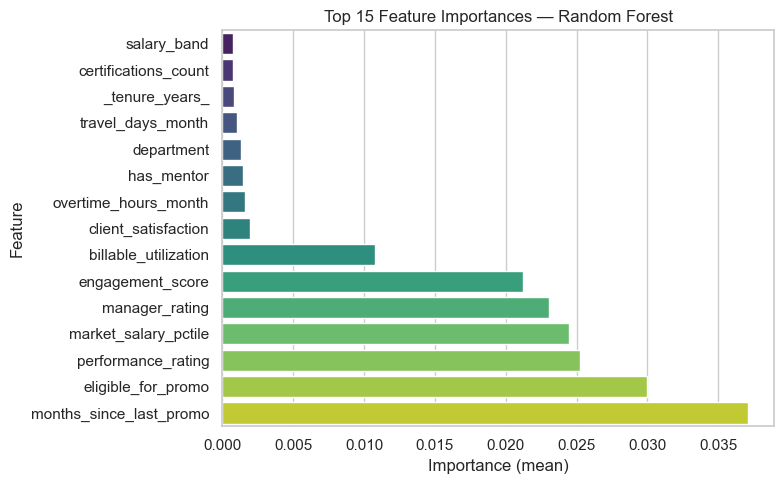

C:\Users\cstam\AppData\Local\Temp\ipykernel_24748\2724215184.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="importance_mean", y="feature", palette="viridis")


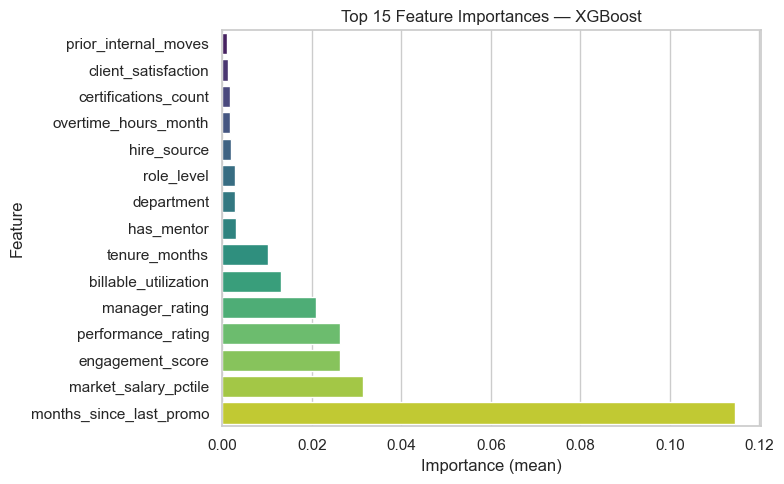

In [13]:
# ============================================================
# Plot feature importances (horizontal bar chart)
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importances(df_imp, model_name="Model", top_n=15, filename=None):
    """
    df_imp: DataFrame with columns ["feature", "importance_mean"]
    model_name: str, label for plot title
    top_n: int, number of top features to show
    filename: optional str, path to save the plot
    """
    # Take top features
    df_plot = df_imp.sort_values("importance_mean", ascending=False).head(top_n)[::-1]

    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_plot, x="importance_mean", y="feature", palette="viridis")
    plt.title(f"Top {top_n} Feature Importances — {model_name}")
    plt.xlabel("Importance (mean)")
    plt.ylabel("Feature")

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()


# Example usage:
plot_feature_importances(rf_perm_imp_orig, model_name="Random Forest", top_n=15,
                         filename="rf_feature_importances.png")

plot_feature_importances(xgb_perm_imp_orig, model_name="XGBoost", top_n=15,
                         filename="xgb_feature_importances.png")


C:\Users\cstam\AppData\Local\Temp\ipykernel_24748\1181865148.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="coef", y="feature", palette="coolwarm", dodge=False)


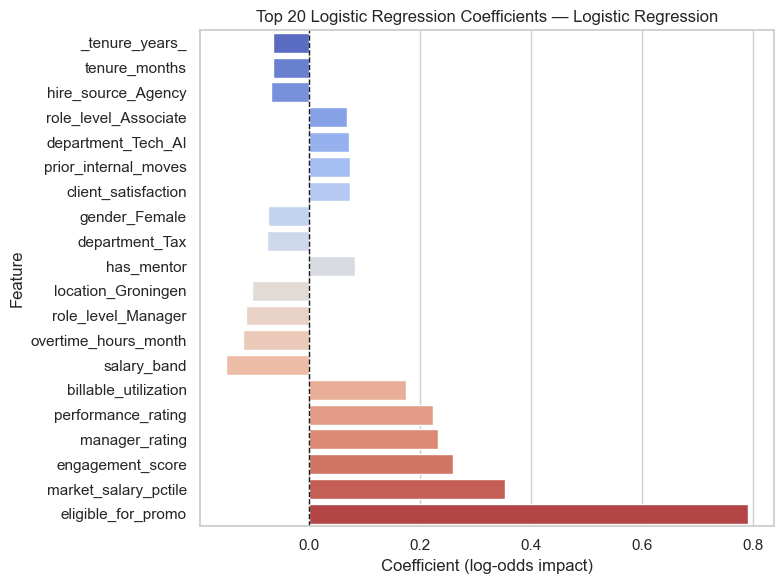

In [14]:
# ============================================================
# Plot Logistic Regression coefficients
# ============================================================
def plot_logistic_coeffs(df_coefs, model_name="Logistic Regression", top_n=20, filename=None):
    """
    df_coefs: DataFrame with columns ["feature", "coef"]
    model_name: str, label for plot title
    top_n: int, number of features (highest absolute coef) to show
    filename: optional str, path to save the plot
    """
    # Select top_n by absolute value
    df_plot = df_coefs.reindex(df_coefs["coef"].abs().sort_values(ascending=False).index)
    df_plot = df_plot.head(top_n)[::-1]  # reverse for nicer barplot

    plt.figure(figsize=(8, 6))
    sns.barplot(data=df_plot, x="coef", y="feature", palette="coolwarm", dodge=False)
    plt.axvline(0, color="k", linestyle="--", linewidth=1)
    plt.title(f"Top {top_n} Logistic Regression Coefficients — {model_name}")
    plt.xlabel("Coefficient (log-odds impact)")
    plt.ylabel("Feature")

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()


# Example usage:
# Assuming your logistic coefficients DataFrame is called logit_coeffs
plot_logistic_coeffs(logit_coeffs, model_name="Logistic Regression", top_n=20,
                     filename="logit_coeffs.png")


In [15]:
# ============================================================
# Identify example employees: Top 10 vs Bottom 10
# ============================================================

# Use the best-performing model (say XGBoost)
best_model = xgb_search.best_estimator_

# Predicted probabilities
y_proba = best_model.predict_proba(X_test)[:, 1]

# Add to test set
df_results = X_test.copy()
df_results["actual_promotion"] = y_test.values
df_results["predicted_prob"] = y_proba

# Sort by predicted probability
top10 = df_results.sort_values("predicted_prob", ascending=False).head(10)
bottom10 = df_results.sort_values("predicted_prob", ascending=True).head(10)

print("=== Top 10 Likely Promotions (model prediction) ===")
display(top10[["predicted_prob", "actual_promotion", "department", "role_level", "performance_rating", "engagement_score", "has_mentor"]])

print("\n=== Bottom 10 (unlikely promotions, may need attention) ===")
display(bottom10[["predicted_prob", "actual_promotion", "department", "role_level", "performance_rating", "engagement_score", "has_mentor"]])


=== Top 10 Likely Promotions (model prediction) ===


,predicted_prob,actual_promotion,department,role_level,performance_rating,engagement_score,has_mentor
1117,0.932567,1,Advisory,Associate,4.58,70.2,0
1626,0.924835,1,Advisory,Associate,4.08,84.6,0
3112,0.911112,1,Assurance,Associate,4.21,98.9,1
3656,0.910107,1,Advisory,Associate,4.71,81.6,1
1335,0.899978,1,Advisory,Senior_Associate,4.43,78.0,0
480,0.890348,1,Assurance,Associate,4.66,71.0,1
468,0.883110,1,Tax,Associate,4.59,100.0,0
2152,0.881340,1,Tax,Associate,4.27,85.2,1
1979,0.881175,1,HR,Associate,4.68,83.6,0
2173,0.880181,1,Advisory,Senior_Associate,4.70,74.6,0



=== Bottom 10 (unlikely promotions, may need attention) ===


,predicted_prob,actual_promotion,department,role_level,performance_rating,engagement_score,has_mentor
3117,0.015260,0,Tax,Associate,3.67,50.7,0
845,0.019101,0,Advisory,Associate,2.69,72.6,0
4658,0.019560,0,Tax,Associate,2.07,61.5,1
3403,0.021692,0,Assurance,Associate,3.27,59.9,0
4536,0.023068,0,Deals,Senior_Associate,3.59,79.6,0
5194,0.024297,0,Advisory,Associate,2.26,61.1,0
5511,0.025042,0,Assurance,Associate,2.86,50.1,1
2486,0.027208,0,Tech_AI,Associate,3.52,64.2,0
4105,0.028754,0,Assurance,Associate,2.78,67.9,1
4258,0.029244,1,Assurance,Associate,3.48,66.6,1


=== Time Saving Estimate ===
Employees reviewed: 5000
Manual review time per employee: 0.50 hours
Manual total hours: 2,500
AI-assisted total hours: 21
Time saved: 2,479 hours per cycle
Efficiency gain: 99.2%


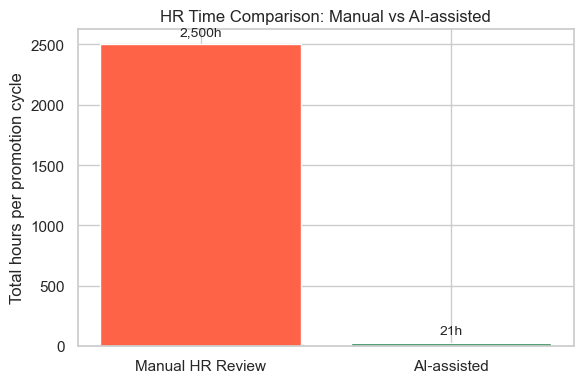

In [19]:
# Assumptions (you can adjust these numbers)
n_employees = 5000                  # employees reviewed
manual_time_per_employee = 0.5      # hours (30 minutes per employee)
manual_total_hours = n_employees * manual_time_per_employee

ai_setup_time = 20                  # hours (validation + oversight)
ai_total_hours = ai_setup_time + 1  # +1 hour to run the notebook

time_saved = manual_total_hours - ai_total_hours
percent_saved = (time_saved / manual_total_hours) * 100

print("=== Time Saving Estimate ===")
print(f"Employees reviewed: {n_employees}")
print(f"Manual review time per employee: {manual_time_per_employee:.2f} hours")
print(f"Manual total hours: {manual_total_hours:,.0f}")
print(f"AI-assisted total hours: {ai_total_hours:,.0f}")
print(f"Time saved: {time_saved:,.0f} hours per cycle")
print(f"Efficiency gain: {percent_saved:.1f}%")

# Optional: Bar chart comparison
methods = ["Manual HR Review", "AI-assisted"]
hours = [manual_total_hours, ai_total_hours]

plt.figure(figsize=(6,4))
bars = plt.bar(methods, hours, color=["tomato", "seagreen"])
plt.title("HR Time Comparison: Manual vs AI-assisted")
plt.ylabel("Total hours per promotion cycle")

# Annotate bars with values
for bar, val in zip(bars, hours):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f"{val:,.0f}h", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.savefig("time.png",dpi=300)
plt.show()

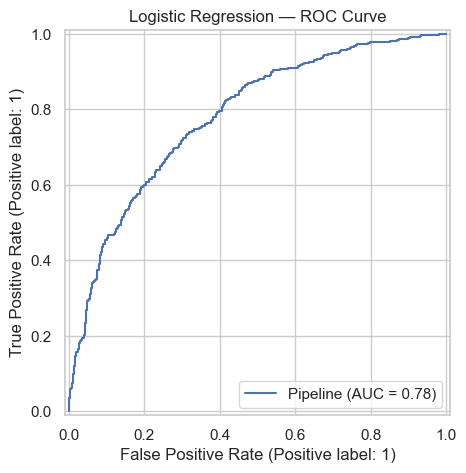

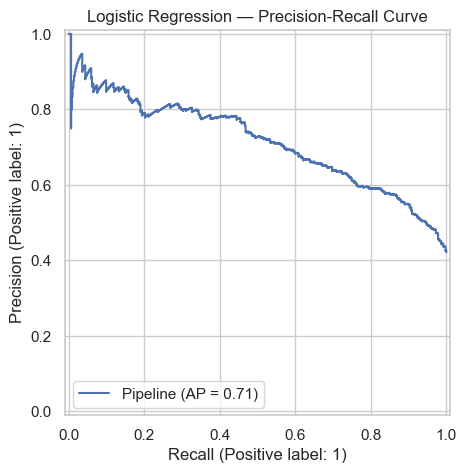

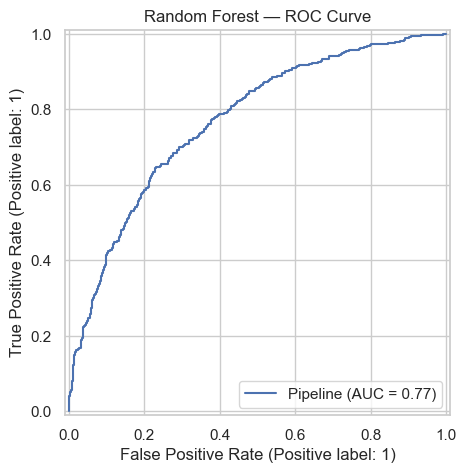

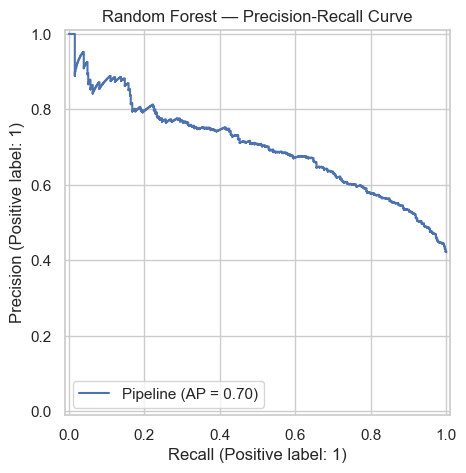

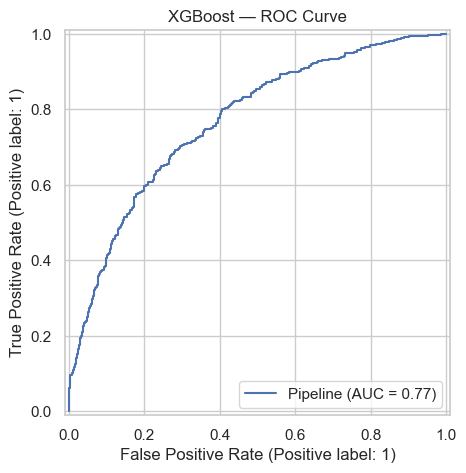

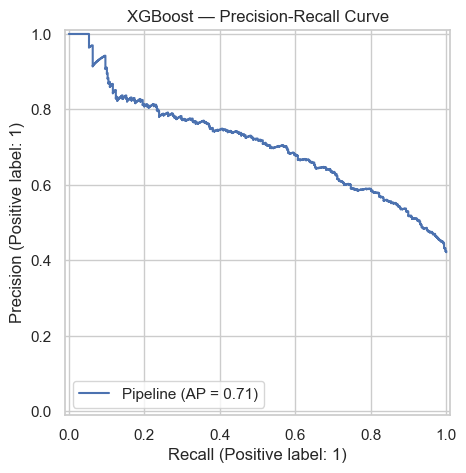

Saved ROC and PR curves to: C:\Users\cstam\plots_model_curves


In [17]:
# ============================================================
# Reproduce and Save ROC + PR Curves for Trained Models
# ============================================================
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import os

CURVE_DIR = "plots_model_curves"
os.makedirs(CURVE_DIR, exist_ok=True)

# List of models
models = {
    "Logistic Regression": logit_search.best_estimator_,
    "Random Forest": rf_search.best_estimator_,
    "XGBoost": xgb_search.best_estimator_
}

# Loop through models and plot curves
for name, clf in models.items():
    # ROC curve
    fig, ax = plt.subplots(figsize=(6, 5))
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax)
    plt.title(f"{name} — ROC Curve")
    plt.savefig(os.path.join(CURVE_DIR, f"{name.lower().replace(' ', '_')}_roc_curve.png"), dpi=300)
    plt.show()

    # Precision-Recall curve
    fig, ax = plt.subplots(figsize=(6, 5))
    PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax=ax)
    plt.title(f"{name} — Precision-Recall Curve")
    plt.savefig(os.path.join(CURVE_DIR, f"{name.lower().replace(' ', '_')}_pr_curve.png"), dpi=300)
    plt.show()

print(f"Saved ROC and PR curves to: {os.path.abspath(CURVE_DIR)}")


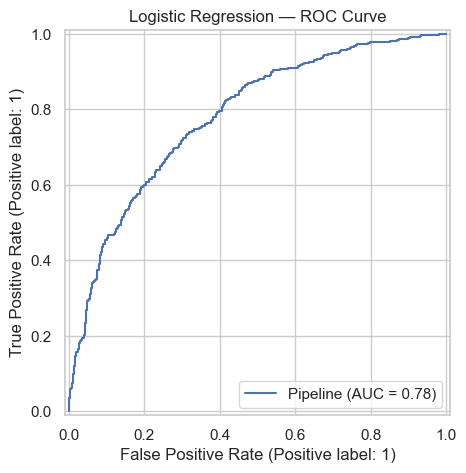

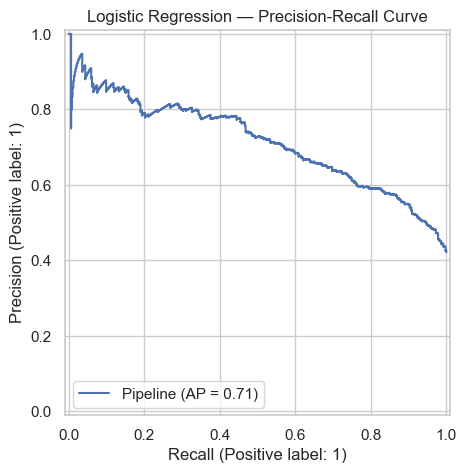

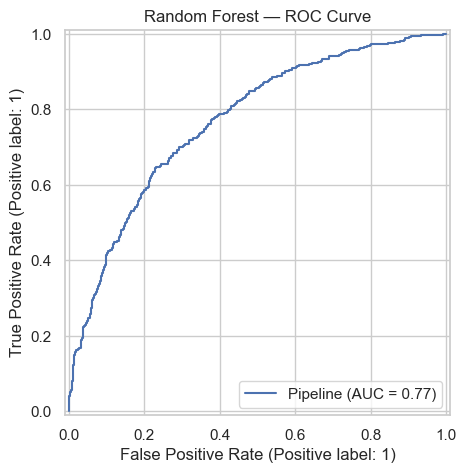

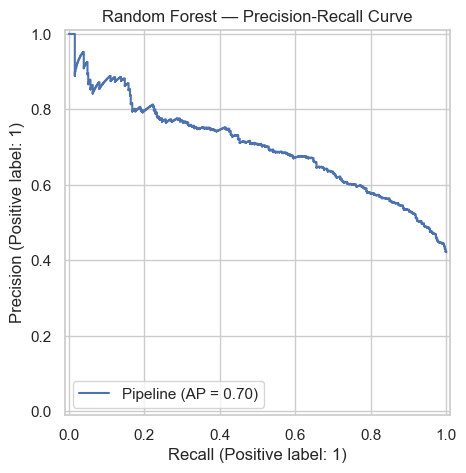

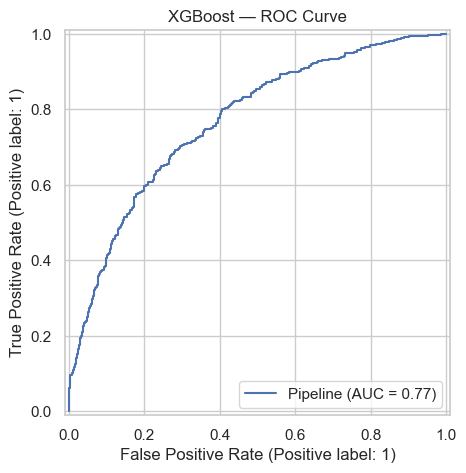

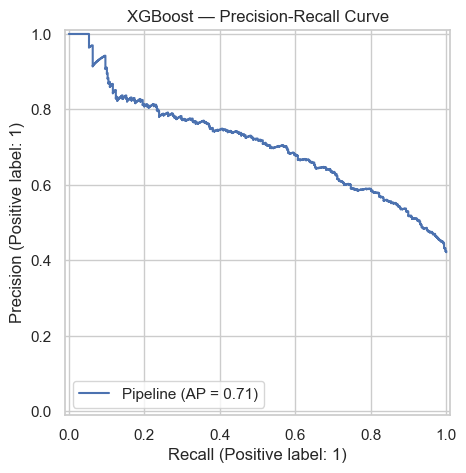

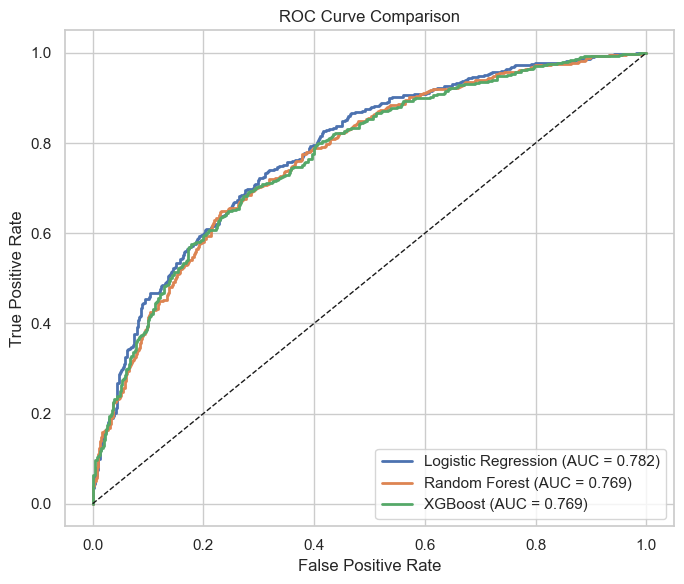

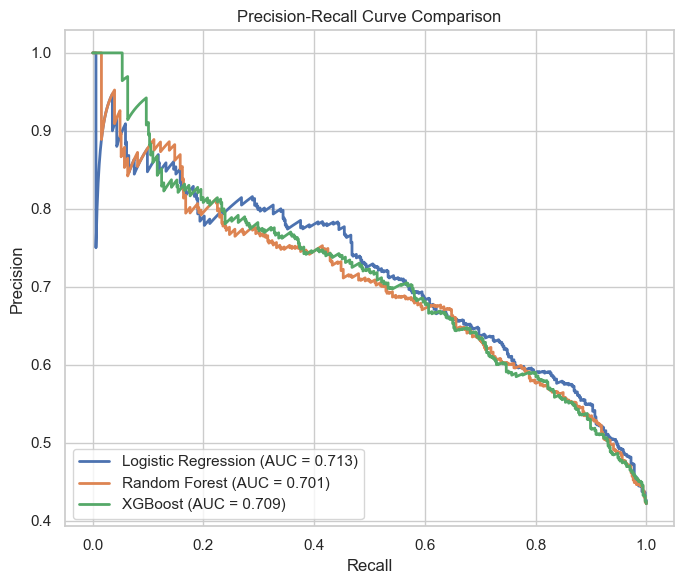

All curves saved to: C:\Users\cstam\plots_model_curves


In [18]:
# ============================================================
# Save Individual and Combined ROC + PR Curves
# ============================================================
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import os

CURVE_DIR = "plots_model_curves"
os.makedirs(CURVE_DIR, exist_ok=True)

# Models to evaluate
models = {
    "Logistic Regression": logit_search.best_estimator_,
    "Random Forest": rf_search.best_estimator_,
    "XGBoost": xgb_search.best_estimator_
}

# ------------------------------------------------------------
# 1) Individual plots
# ------------------------------------------------------------
for name, clf in models.items():
    # ROC curve
    fig, ax = plt.subplots(figsize=(6, 5))
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax)
    plt.title(f"{name} — ROC Curve")
    plt.savefig(os.path.join(CURVE_DIR, f"{name.lower().replace(' ', '_')}_roc_curve.png"), dpi=300)
    plt.show()

    # PR curve
    fig, ax = plt.subplots(figsize=(6, 5))
    PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax=ax)
    plt.title(f"{name} — Precision-Recall Curve")
    plt.savefig(os.path.join(CURVE_DIR, f"{name.lower().replace(' ', '_')}_pr_curve.png"), dpi=300)
    plt.show()

# ------------------------------------------------------------
# 2) Combined plots
# ------------------------------------------------------------
# ROC combined
plt.figure(figsize=(7,6))
for name, clf in models.items():
    y_proba = clf.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(CURVE_DIR, "combined_roc_curve.png"), dpi=300)
plt.show()

# PR combined
plt.figure(figsize=(7,6))
for name, clf in models.items():
    y_proba = clf.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f"{name} (AUC = {pr_auc:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig(os.path.join(CURVE_DIR, "combined_pr_curve.png"), dpi=300)
plt.show()

print(f"All curves saved to: {os.path.abspath(CURVE_DIR)}")
